## testing preprocessing

Just going to use a simple script for the WMH challenge dataset.

Steps need to be 
- [x] brain extraction
- [x] normalize
- [x] resample

the WMH mask only has the resample function applied to it. (it should have two classes - one for 'other pathology'.

add functionality to skip a file if it already exists (and hence create a temp file, so that I can run the script in parallel on multiple nodes).

I am not doing a bias correction, because I am going to use the 'pre' files provided by the challenge that bias correct the flair and T1.

I should define a separate script that parses the WMH challenge folder and provides the paths for input and output.

I need three output files, 

In [73]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### building the parser for the dataset

In [74]:
import os
from collections import defaultdict

In [75]:
ds_path = "/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset"

In [76]:
# I am doing to want separate files for each train and test domain. however, for now, I can just save each image by its ID as a separate file. nice.
# make sure to include that information this time in the collated data...
# this parser should just return the FLAIR, T1, WMH file paths for each ID, and note 
# whether they are train or test, which domain, and what is the ID.

# The domains will be Singapore, Amsterdam, Utretch

In [77]:
files_dict = defaultdict(lambda: {})
output_folder = os.path.sep.join([ds_path, 'preprocessed', 'individual_files'])

for fold in ['training', 'test']:
    for domain in ['Amsterdam_GE3T', 'Singapore', 'Utrecht', 'Amsterdam_GE1T5', 'Amsterdam_Philips_VU_PETMR_01']:
        domain_path = os.path.sep.join([ds_path, fold, domain])
        if os.path.exists(domain_path):
            num_ids = os.listdir(domain_path)
            for nid in num_ids:
                ind_path = f'{domain_path}{os.path.sep}{nid}{os.path.sep}'
                t1_path = f'{ind_path}pre{os.path.sep}T1.nii.gz'
                flair_path = f'{ind_path}pre{os.path.sep}FLAIR.nii.gz'
                wmh_path = f'{ind_path}wmh.nii.gz'

                full_id = f'{fold}_{domain}_{nid}'

                files_dict[full_id] = {
                    'FLAIR':flair_path,
                    'T1':t1_path,
                    'wmh':wmh_path,
                    'fold':fold,
                    'domain':domain,
                    'id':nid,
                    'out_path': f'{output_folder}{os.path.sep}{full_id}'
                }

### What is the actual spacing for each domain according to sitk?
Everything is already nearly 1,1,3 so it makes sense to resample to that. Okay so we expect the slice numbers to not change much if at all, which is inline with what we see.
Okay resampling function is going okay, next thing to fix is now the normalization....

In [78]:
sitk.ReadImage(file_info['FLAIR']).GetSize()

(321, 240, 83)

In [79]:
import SimpleITK as sitk

In [80]:
for fid, file_info in files_dict.items():
    flair = sitk.ReadImage(file_info['FLAIR'])
    print(fid, flair.GetSpacing(), flair.GetSize())
    # break

training_Amsterdam_GE3T_100 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_101 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_102 (1.1999001502990723, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_103 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_104 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_105 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_106 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_107 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_108 (1.1999847888946533, 0.9765999913215637, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_109 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_110 (1.2000000476837158, 0.976599931716919, 3.0) (132, 256, 83)
training_Amsterdam_GE3T_112 (1.

### writing the preprocessing pipeline

In [81]:
%autoreload

In [82]:
from ulw_data.preprocessing.normalize_brain import *
from ulw_data.preprocessing.resample import *
from ulw_data.preprocessing.skull_strip import *
import nibabel as nib
import os

In [83]:
try:
    os.makedirs(output_folder)
except FileExistsError:
    print("output folder already exists, continuing")

output folder already exists, continuing


In [101]:
cutoff = 0.01
out_spacing = [1., 1., 3.]

def preprocess(file_dict, force=False):
    flair = file_dict['FLAIR']
    t1 = file_dict['T1']
    wmh = file_dict['wmh']
    out_path = file_dict['out_path']

    flair_out_path = f'{out_path}_FLAIR.nii.gz'
    t1_out_path = f'{out_path}_T1.nii.gz'
    mask_out_path = f'{out_path}_mask.nii.gz'
    wmh_out_path = f'{out_path}_wmh.nii.gz'

    # create a file used to let other processes
    # know this file is being processed.
    # a simple hack, allows me to run this script
    # across multiple unconnected efficiency, and
    # there are no race conditions here so doesn't
    # matter if two threads occasionally process the same file
    skip_file = f'{out_path}_skip_file.txt'
    if not force and os.path.exists(skip_file):
        print("skipping, file exists")
        return
        
    with open(skip_file, "w") as f:
            f.write(f"processing {out_path}")

    # resampling before we do anything else now, otherwise the hard thresholds put in place by the mask
    # can get lost at either end of the mask.
    print('# resample the flair')
    resample_and_save(flair, flair_out_path, is_label=False, out_spacing=out_spacing)
    
    print('# resample the T1')
    resample_and_save(t1, t1_out_path, is_label=False, out_spacing=out_spacing)
    
    print('# resample the wmh')
    resample_and_save(wmh, wmh_out_path, is_label=True, out_spacing=out_spacing)

    # compute the mask 
    print('# load files')
    t1 = nib.load(t1_out_path)
    print(t1.get_fdata().shape)
    flair = nib.load(flair_out_path)

    print('# compute mask and skull strip the T1')
    t1, mask = skull_strip(t1)
    print(t1.get_fdata().shape, mask.get_fdata().shape)
    nib.save(mask, mask_out_path)
    
    print('# skull strip the FLAIR')
    flair = apply_mask(flair, mask)
    
    print('# normalize the FLAIR')
    flair = nib_normalize_brain(flair, mask)
    nib.save(flair, flair_out_path)

    print('# normalize the T1')
    t1 = nib_normalize_brain(t1, mask)
    nib.save(t1, t1_out_path)
    
    print('# done!')

In [85]:
islice_a = 55

# load files


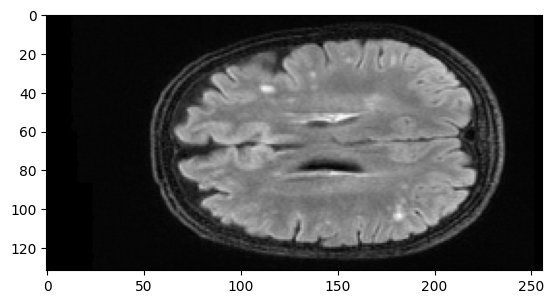

In [91]:
file_dict = files_dict['training_Amsterdam_GE3T_100']

flair = file_dict['FLAIR']
t1 = file_dict['T1']
wmh = file_dict['wmh']
out_path = file_dict['out_path']

print('# load files')
t1 = nib.load(t1)
flair = nib.load(flair)
plt.imshow(flair.get_fdata()[:,:,islice_a], cmap='gray')

In [94]:
t1.shape

(132, 256, 83)

In [87]:
print('# skull strip the T1')
t1, mask = skull_strip(t1)
nib.save(mask, f'{out_path}_mask.nii.gz')

# skull strip the T1


In [88]:
np.unique(mask.get_fdata())

array([0., 1.])

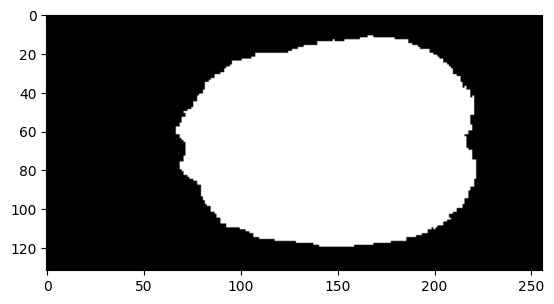

In [89]:
plt.imshow(mask.get_fdata()[:,:,islice_a], cmap='gray')

# skull strip the FLAIR


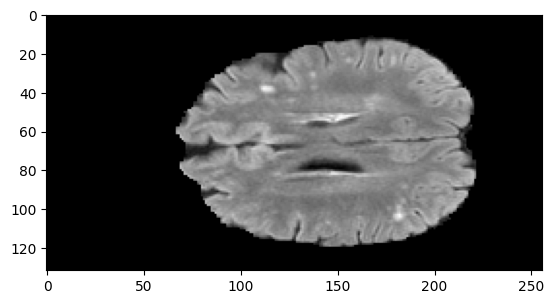

In [90]:
flair = file_dict['FLAIR']
flair = nib.load(flair)
print('# skull strip the FLAIR')

# image_data = flair.get_fdata()
# mask_data = image.get_fdata()
# new_image = nib.nifti1.Nifti1Image(image_data * mask_data, affine=image.affine, header=image.header)
flair = apply_mask(flair, mask)

plt.imshow(flair.get_fdata()[:,:,islice_a], cmap='gray')

In [30]:
flair

In [51]:
#mask.get_fdata().astype(bool)

# normalize the FLAIR


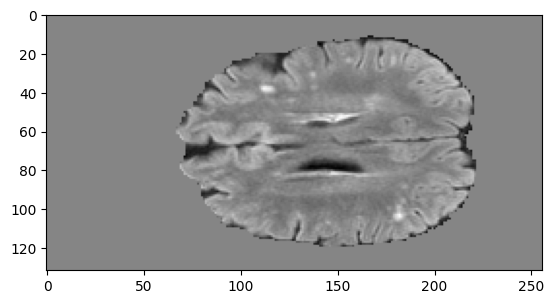

In [47]:
print('# normalize the FLAIR')
flair = nib_normalize_brain(flair, mask)
temp_flair_file = f'{out_path}_FLAIR_temp.nii.gz'
nib.save(flair, temp_flair_file)

plt.imshow(flair.get_fdata()[:,:,islice_a], cmap='gray')

In [49]:
temp_flair = nib.load(temp_flair_file)

In [52]:
temp_flair.shape

(132, 256, 83)

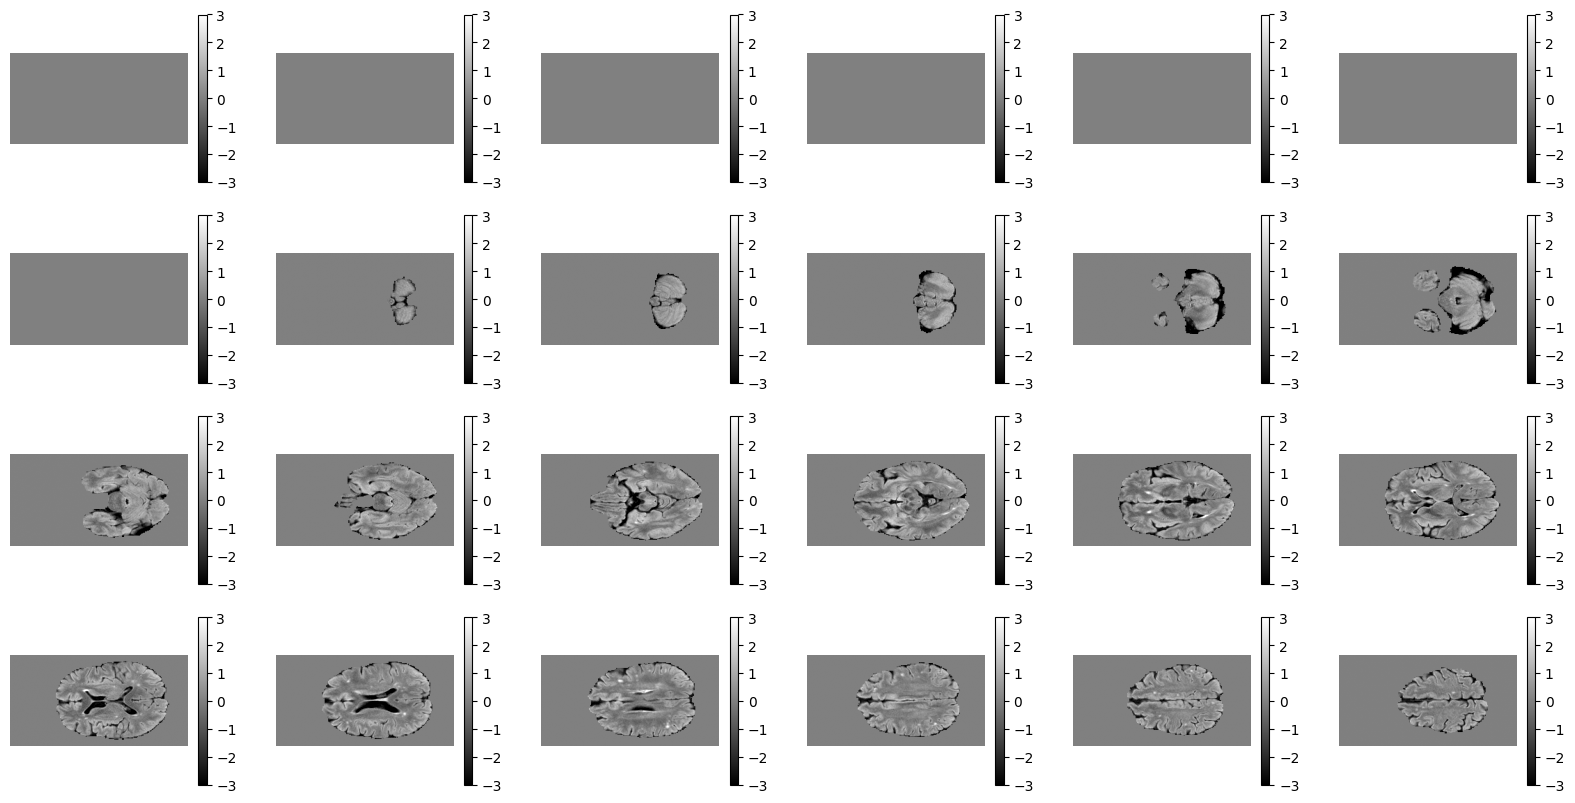

In [60]:
plt.figure(figsize=(20, 10))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(temp_flair.get_fdata()[:,:,i*2+15], cmap='gray', vmin=-3, vmax=3)
    plt.colorbar()
    plt.axis('off');

### examine the before and the after

In [64]:
preprocess(files_dict['training_Amsterdam_GE3T_100'], force=True)

# resample the flair
original spacing:  None
using original spacing derived from image
# resample the T1
original spacing:  None
using original spacing derived from image
# resample the wmh
original spacing:  None
using original spacing derived from image
# load files
# compute mask and skull strip the T1
# skull strip the FLAIR
# normalize the FLAIR
# normalize the T1
# done!


In [65]:
def load(fp):
    return nib.load(fp).get_fdata()

In [103]:
file_dict = files_dict['training_Amsterdam_GE3T_100']
flair = load(file_dict['FLAIR'])
t1 = load(file_dict['T1'])
wmh = load(file_dict['wmh'])
out_flair = load(file_dict['out_path'] + "_FLAIR.nii.gz")
out_t1 = load(file_dict['out_path'] + "_T1.nii.gz")
out_wmh = load(file_dict['out_path'] + "_wmh.nii.gz")
out_mask = load(file_dict['out_path'] + "_mask.nii.gz")

In [104]:
out_mask.shape

(158, 250, 83)

In [100]:
t1.shape

(132, 256, 83)

In [67]:
wmh.shape, flair.shape

((132, 256, 83), (132, 256, 83))

In [68]:
np.unique(out_wmh)

array([0., 1.])

(-0.5, 249.5, 157.5, -0.5)

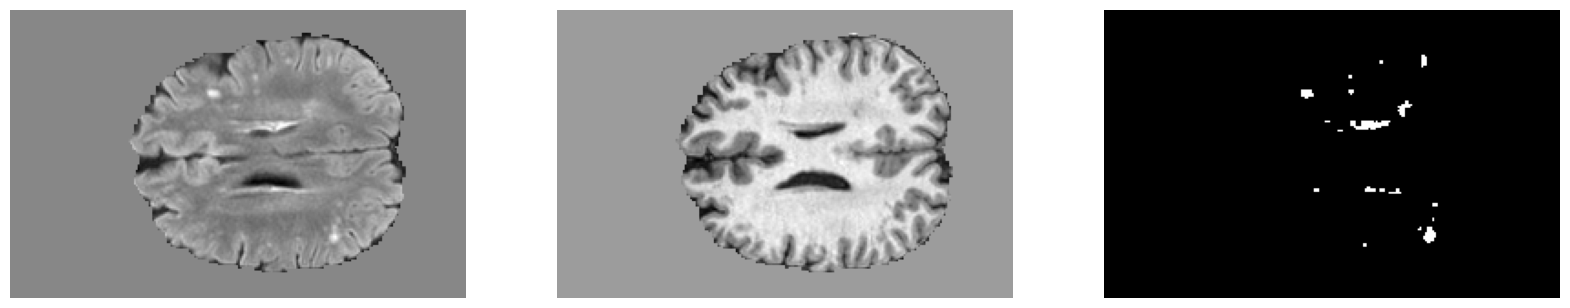

In [69]:
islice_a = 55
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(out_flair[:,:,islice_a], cmap='gray'); plt.axis('off')
# plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(out_t1[:,:,islice_a], cmap='gray'); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(out_wmh[:,:,islice_a], cmap='gray'); plt.axis('off')

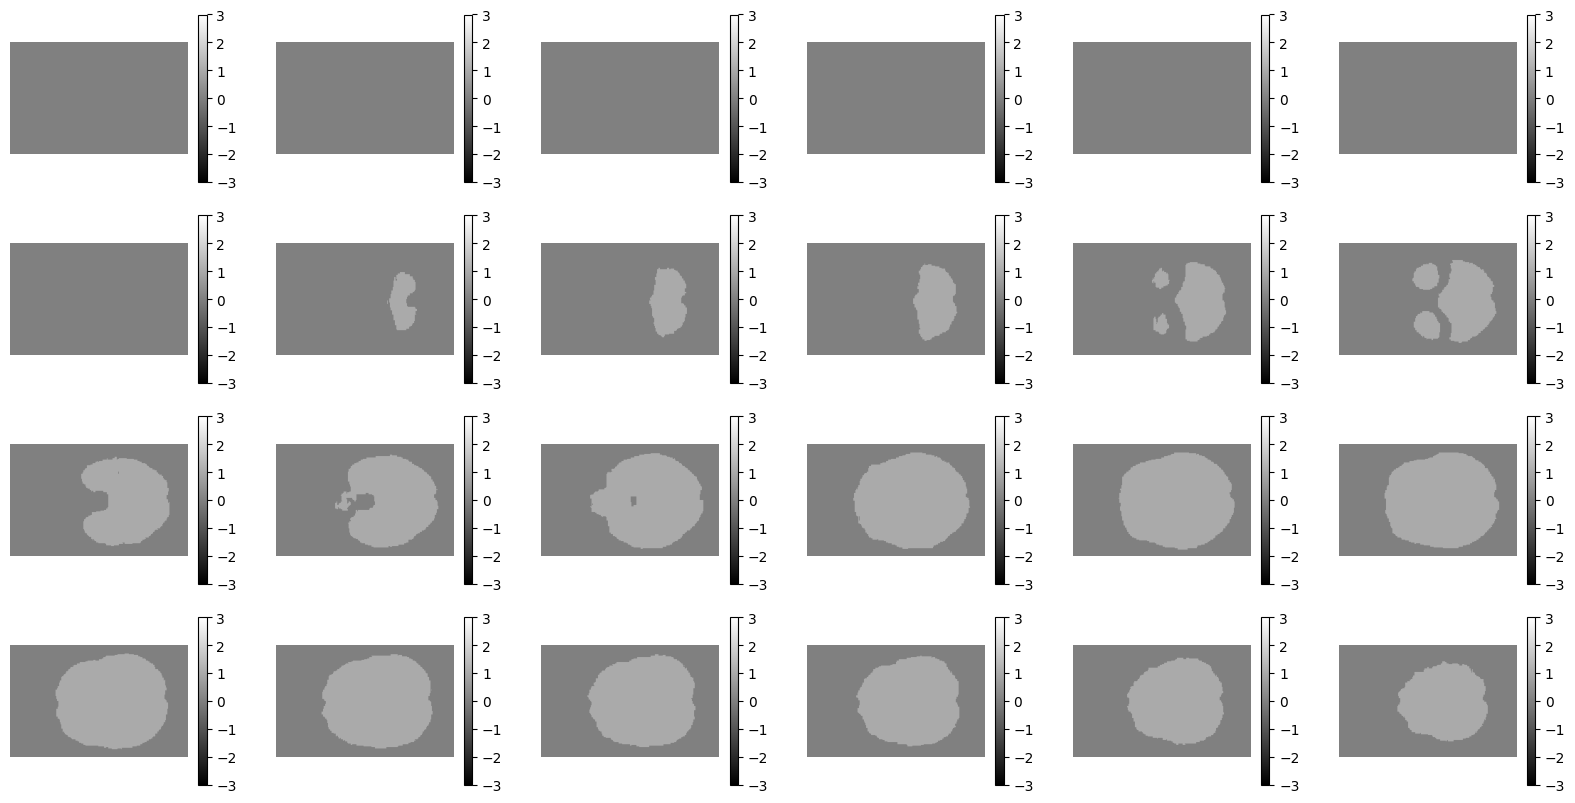

In [72]:
plt.figure(figsize=(20, 10))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(out_mask[:,:,i*2+15], cmap='gray', vmin=-3, vmax=3)
    plt.colorbar()
    plt.axis('off');

(-0.5, 255.5, 131.5, -0.5)

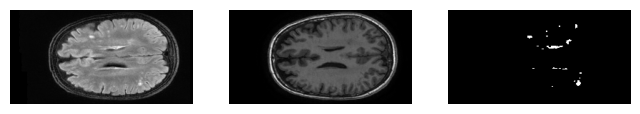

In [222]:
islice_a = 55
plt.figure(figsize=(8,5))
plt.subplot(1,3,1)
plt.imshow(flair[:,:,islice_a], cmap='gray'); plt.axis('off')
# plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(t1[:,:,islice_a], cmap='gray'); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wmh[:,:,islice_a], cmap='gray'); plt.axis('off')

In [102]:
preprocess(files_dict['training_Amsterdam_GE3T_100'], force=True)

# resample the flair
# resample the T1
# resample the wmh
# load files
(158, 250, 83)
# compute mask and skull strip the T1
(158, 250, 83) (158, 250, 83)
# skull strip the FLAIR
# normalize the FLAIR
# normalize the T1
# done!


In [224]:
# order of preprocessing. Take the t1 and skull strip it.
# save the mask
# use the mask to strip the FLAIR.
# normalize the flair and the t1
# resample both the flair and t1.
# save. Done.

# needs to take in the files dict as an argument

def run_loop(files_dict):

    for fid, f_dict in files_dict.items():
        print(f'#  processing {fid}')
        preprocess(f_dict)

In [226]:
run_loop(files_dict)

#  processing training_Amsterdam_GE3T_100
skipping, file exists
#  processing training_Amsterdam_GE3T_101
skipping, file exists
#  processing training_Amsterdam_GE3T_102
skipping, file exists
#  processing training_Amsterdam_GE3T_103
skipping, file exists
#  processing training_Amsterdam_GE3T_104
skipping, file exists
#  processing training_Amsterdam_GE3T_105
skipping, file exists
#  processing training_Amsterdam_GE3T_106
skipping, file exists
#  processing training_Amsterdam_GE3T_107
skipping, file exists
#  processing training_Amsterdam_GE3T_108
skipping, file exists
#  processing training_Amsterdam_GE3T_109
skipping, file exists
#  processing training_Amsterdam_GE3T_110
skipping, file exists
#  processing training_Amsterdam_GE3T_112
skipping, file exists
#  processing training_Amsterdam_GE3T_113
skipping, file exists
#  processing training_Amsterdam_GE3T_114
skipping, file exists
#  processing training_Amsterdam_GE3T_115
skipping, file exists
#  processing training_Amsterdam_GE3T_11

In [54]:
files_dict['training_Amsterdam_GE3T_100']

{'FLAIR': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/training/Amsterdam_GE3T/100/pre/FLAIR.nii.gz',
 'T1': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/training/Amsterdam_GE3T/100/pre/T1.nii.gz',
 'wmh': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/training/Amsterdam_GE3T/100/wmh.nii.gz',
 'fold': 'training',
 'domain': 'Amsterdam_GE3T',
 'id': '100',
 'out_path': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/preprocessed/individual_files/training_Amsterdam_GE3T_100_'}

In [ ]:
### Writing the file collation pipeline.